In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

# print with precision 5
%precision 5
pd.set_option('precision', 5)

### 4.6.1 The Stock Market Data
We will begin by examining some numerical and graphical summaries of
the Smarket data, which is part of the ISLR library. This data set consists of
percentage returns for the S&P 500 stock index over 1, 250 days, from the
beginning of 2001 until the end of 2005. For each date, we have recorded
the percentage returns for each of the five previous trading days, Lag1
through Lag5. We have also recorded Volume (the number of shares traded on the previous day, in billions), Today (the percentage return on the date
in question) and Direction (whether the market was Up or Down on this
date).




In [2]:
market = pd.read_csv('Data/Smarket.csv')
market.drop(columns = 'Unnamed: 0', inplace = True)
market.head()
display("Shape :")
market.shape
market.describe()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up


'Shape :'

(1250, 9)

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
count,1250.00000,1250.00000,1250.00000,1250.00000,1250.00000,1250.00000,1250.00000,1250.00000
mean,2003.01600,0.00383,0.00392,0.00172,0.00164,0.00561,1.47830,0.00314
std,1.40902,1.13630,1.13628,1.13870,1.13877,1.14755,0.36036,1.13633
min,2001.00000,-4.92200,-4.92200,-4.92200,-4.92200,-4.92200,0.35607,-4.92200
25%,2002.00000,-0.63950,-0.63950,-0.64000,-0.64000,-0.64000,1.25740,-0.63950
50%,2003.00000,0.03900,0.03900,0.03850,0.03850,0.03850,1.42295,0.03850
75%,2004.00000,0.59675,0.59675,0.59675,0.59675,0.59700,1.64167,0.59675
max,2005.00000,5.73300,5.73300,5.73300,5.73300,5.73300,3.15247,5.73300


The corr() function produces a matrix that contains all of the pairwise
correlations among the predictors in a data set except Direction, because the Direction variable is qualitative.

In [3]:
market.corr()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.00000,0.02970,0.03060,0.03319,0.03569,0.02979,0.53901,0.03010
Lag1,0.02970,1.00000,-0.02629,-0.01080,-0.00299,-0.00567,0.04091,-0.02616
Lag2,0.03060,-0.02629,1.00000,-0.02590,-0.01085,-0.00356,-0.04338,-0.01025
Lag3,0.03319,-0.01080,-0.02590,1.00000,-0.02405,-0.01881,-0.04182,-0.00245
Lag4,0.03569,-0.00299,-0.01085,-0.02405,1.00000,-0.02708,-0.04841,-0.00690
Lag5,0.02979,-0.00567,-0.00356,-0.01881,-0.02708,1.00000,-0.02200,-0.03486
Volume,0.53901,0.04091,-0.04338,-0.04182,-0.04841,-0.02200,1.00000,0.01459
Today,0.03010,-0.02616,-0.01025,-0.00245,-0.00690,-0.03486,0.01459,1.00000


As one would expect, the correlations between the lag variables and today’s returns are close to zero. In other words, there appears to be little
correlation between today’s returns and previous days’ returns. The only
substantial correlation is between Year and Volume. By plotting the data we
see that Volume is increasing over time. In other words, the average number
of shares traded daily increased from 2001 to 2005.

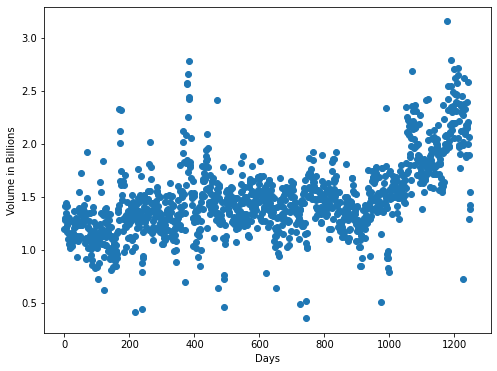

In [4]:
fig, ax = plt.subplots(figsize = (8,6))
ax.scatter(market.index, market.Volume);
ax.set_xlabel('Days');
ax.set_ylabel('Volume in Billions');

### 4.6.2 Logistic Regression
Next, we will fit a logistic regression model in order to predict Direction
using Lag1 through Lag5 and Volume. The LogisticRegression function from sklearn fits generalized a logistic regression. The parameters are set such that the result is consisentent with the glm() function from R.

In [5]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression( fit_intercept = True, solver='newton-cg', penalty = 'none')
model.fit(market.filter(items =["Lag1","Lag2","Lag3","Lag4","Lag5","Volume"]), market["Direction"])

coefs = pd.DataFrame(np.c_[model.intercept_,model.coef_]).transpose()
labels = ["Intercept","Lag1","Lag2","Lag3","Lag4","Lag5","Volume"]
coefs.index = labels
coefs.columns = ["Fit"]
coefs

LogisticRegression(penalty='none', solver='newton-cg')

,Fit
Intercept,-0.12600
Lag1,-0.07307
Lag2,-0.04230
Lag3,0.01109
Lag4,0.00936
Lag5,0.01031
Volume,0.13544


Now, sklearn is good for smart and convenient ML applications, but it's not really good at Stats: we can't get p-values with it. We will therefore do the same using the Statsmodels package.
The only difference is that we can't do qualitative variables, so we need to code Directions with 0 and 1.

In [6]:

market["BinDirection"] = market['Direction'].astype('category').cat.codes
logit_fit = smf.logit('BinDirection ~ Lag1 + Lag2 + Lag3 + Lag4 + Lag5 + Volume', market).fit()
logit_fit.summary()

Optimization terminated successfully.
         Current function value: 0.691034
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           BinDirection   No. Observations:                 1250
Model:                          Logit   Df Residuals:                     1243
Method:                           MLE   Df Model:                            6
Date:                Sun, 31 Jan 2021   Pseudo R-squ.:                0.002074
Time:                        19:18:19   Log-Likelihood:                -863.79
converged:                       True   LL-Null:                       -865.59
Covariance Type:            nonrobust   LLR p-value:                    0.7319
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1260      0.241     -0.523      0.601      -0.598       0.346
Lag1          -0.0731      0.050     -1.457      0.145      -0.171       0.025
Lag2          -0.0423      0.050     -0.845      0.398      -0.140       0.056
Lag3           0.0111      0.050      0.222      0.824      -0.087       0.109
Lag4           0.0094      0.050      0.187      0.851      -0.089       0.107
Lag5           0.0103      0.050      0.208      0.835      -0.087       0.107
Volume         0.1354      0.158      0.855      0.392      -0.175       0.446
==============================================================================
"""

The smallest p-value here is associated with `Lag1`. The negative coefficient
for this predictor suggests that if the market had a positive return yesterday,
then it is less likely to go up today. However, at a value of `0.15`, the p-value
is still relatively large, and so there is no clear evidence of a real association
between `Lag1` and `Direction`.
We use the `params` attributes in order to access just the coefficients for this
fitted model. We can also use the `describe()` function to access particular
aspects of the fitted model, such as the p-values for the coefficients.

In [7]:
logit_fit.params

Intercept   -0.12600
Lag1        -0.07307
Lag2        -0.04230
Lag3         0.01109
Lag4         0.00936
Lag5         0.01031
Volume       0.13544
dtype: float64

The `predict()` function can be used to predict the probability that the
market will go up, given values of the predictors. We output probabilities of the form P(Y = 1|X), as opposed
to other information such as the logit. If no data set is supplied to the
predict() function, then the probabilities are computed for the training
data that was used to fit the logistic regression model. Here we have printed
only some probabilities.

In [8]:
probs = logit_fit.predict()
probs

array([0.50708, 0.48147, 0.48114, ..., 0.53927, 0.52612, 0.51792])

In order to make a prediction as to whether the market will go up or
down on a particular day, we must convert these predicted probabilities
into class labels, Up or Down. The following two commands create a vector
of class predictions based on whether the predicted probability of a market
increase is greater than or less than 0.5.

In [9]:
predictions = np.repeat("Down", 1250)
predictions[probs > 0.5] = "Up"

from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_true = market["Direction"], y_pred = predictions)
conf_matrix = pd.DataFrame(conf_matrix,index = ["Predicted Down", "Predicted Up"], columns = ["True Down", "True Up"])
conf_matrix
print(f"Correctly guessed:{np.sum(np.diag(conf_matrix))/conf_matrix.values.sum()} ")

,True Down,True Up
Predicted Down,145,457
Predicted Up,141,507


Correctly guessed:0.5216 


The first command creates a vector of 1,250 Down elements. The second line
transforms to Up all of the elements for which the predicted probability of a
market increase exceeds 0.5. Given these predictions, the `confusion_matrix()` function from `sklearn`can be used to produce a confusion matrix in order to determine how many
observations were correctly or incorrectly classified.

The diagonal elements of the confusion matrix indicate correct predictions,
while the off-diagonals represent incorrect predictions. Hence our model
correctly predicted that the market would go up on 507 days and that
it would go down on 145 days, for a total of 507 + 145 = 652 correct
predictions. We can compute the fraction of
days for which the prediction was correct. In this case, logistic regression
correctly predicted the movement of the market 52.2 % of the time.
At first glance, it appears that the logistic regression model is working
a little better than random guessing. However, this result is misleading
because we trained and tested the model on the same set of 1250 observations. In other words, 100 − 52.2 = 47.8 % is the training error rate. As we
have seen previously, the training error rate is often overly optimistic—it
tends to underestimate the test error rate. In order to better assess the accuracy of the logistic regression model in this setting, we can fit the model
using part of the data, and then examine how well it predicts the held out
data. This will yield a more realistic error rate, in the sense that in practice we will be interested in our model’s performance not on the data that
we used to fit the model, but rather on days in the future for which the
market’s movements are unknown.

To implement this strategy, we will first create a vector corresponding
to the observations from 2001 through 2004. We will then use this vector
to create a held out data set of observations from 2005.



In [10]:
train = market[market["Year"] <2005]
test =  market[market["Year"] >=2005]
train.shape
test.shape

(998, 10)

(252, 10)

We now fit a logistic regression model using only the subset of the observations that correspond to dates before 2005, using the subset argument.
We then obtain predicted probabilities of the stock market going up for
each of the days in our test set—that is, for the days in 2005.

In [11]:
logit_fit = smf.logit('BinDirection ~ Lag1 + Lag2 + Lag3 + Lag4 + Lag5 + Volume', train).fit()

Optimization terminated successfully.
         Current function value: 0.691936
         Iterations 4


Notice that we have trained and tested our model on two completely separate data sets: training was performed using only the dates before 2005,
and testing was performed using only the dates in 2005. Finally, we compute the predictions for 2005 and compare them to the actual movements
of the market over that time period

In [12]:
# training error
probs = logit_fit.predict(train)
predictions = np.repeat("Down", 998)
predictions[probs > 0.5] = "Up"
conf_matrix = confusion_matrix(y_true = train["Direction"], y_pred = predictions)
conf_matrix = pd.DataFrame(conf_matrix,index = ["Predicted Down", "Predicted Up"], columns = ["Train Down", "Train Up"])
conf_matrix
train_success = np.sum(np.diag(conf_matrix))/conf_matrix.values.sum()
print(f"Correctly guessed on training set:{train_success} ")
print(f" Training error: {1-train_success}")

# test error 
probs = logit_fit.predict(test)
predictions = np.repeat("Down", 252)
predictions[probs > 0.5] = "Up"
conf_matrix = confusion_matrix(y_true = test["Direction"], y_pred = predictions)
conf_matrix = pd.DataFrame(conf_matrix,index = ["Predicted Down", "Predicted Up"], columns = ["Test Down", "Test Up"])
conf_matrix
test_success = np.sum(np.diag(conf_matrix))/conf_matrix.values.sum()
print(f"Correctly guessed on test set:{test_success} ")
print(f" Test error: {1-test_success}")




,Train Down,Train Up
Predicted Down,175,316
Predicted Up,156,351


Correctly guessed on training set:0.5270541082164328 
 Training error: 0.47294589178356716


,Test Down,Test Up
Predicted Down,77,34
Predicted Up,97,44


Correctly guessed on test set:0.4801587301587302 
 Test error: 0.5198412698412698


The results are rather disappointing: the test error
rate is 52 %, which is worse than random guessing! Of course this result
is not all that surprising, given that one would not generally expect to be
able to use previous days’ returns to predict future market performance.
(After all, if it were possible to do so, then the authors of this book would
be out striking it rich rather than writing a statistics textbook.)
We recall that the logistic regression model had very underwhelming pvalues associated with all of the predictors, and that the smallest p-value,
though not very small, corresponded to `Lag1`. Perhaps by removing the
variables that appear not to be helpful in predicting `Direction`, we can
obtain a more effective model. After all, using predictors that have no
relationship with the response tends to cause a deterioration in the test
error rate (since such predictors cause an increase in variance without a
corresponding decrease in bias), and so removing such predictors may in
turn yield an improvement. Below we have refit the logistic regression using
just `Lag1` and `Lag2`, which seemed to have the highest predictive power in
the original logistic regression model.

In [13]:
logit_fit = smf.logit('BinDirection ~ Lag1 + Lag2', train).fit()
# training error
probs = logit_fit.predict(train)
predictions = np.repeat("Down", 998)
predictions[probs > 0.5] = "Up"
conf_matrix = confusion_matrix(y_true = train["Direction"], y_pred = predictions)
conf_matrix = pd.DataFrame(conf_matrix,index = ["Predicted Down", "Predicted Up"], columns = ["Train Down", "Train Up"])
conf_matrix
train_success = round(np.sum(np.diag(conf_matrix))/conf_matrix.values.sum(),2)
print(f"Correctly guessed on training set:{train_success} ")
print(f" Training error: {round(1-train_success, 2)}")
#test error
probs = logit_fit.predict(test)
predictions = np.repeat("Down", 252)
predictions[probs > 0.5] = "Up"
conf_matrix = confusion_matrix(y_true = test["Direction"], y_pred = predictions)
conf_matrix = pd.DataFrame(conf_matrix,index = ["Predicted Down", "Predicted Up"], columns = ["Test Down", "Test Up"])
conf_matrix
test_success = round(np.sum(np.diag(conf_matrix))/conf_matrix.values.sum(),2)
print(f"Correctly guessed on test set:{test_success} ")
print(f" Test error: {round(1-test_success, 2)}")

Optimization terminated successfully.
         Current function value: 0.692085
         Iterations 3


,Train Down,Train Up
Predicted Down,168,323
Predicted Up,160,347


Correctly guessed on training set:0.52 
 Training error: 0.48


,Test Down,Test Up
Predicted Down,35,76
Predicted Up,35,106


Correctly guessed on test set:0.56 
 Test error: 0.44


Now the results appear to be a little better: 56% of the daily movements
have been correctly predicted. It is worth noting that in this case, a much
simpler strategy of predicting that the market will increase every day will
also be correct 56% of the time! Hence, in terms of overall error rate, the
logistic regression method is no better than the na¨ıve approach. However,
the confusion matrix shows that on days when logistic regression predicts
an increase in the market, it has a 58% accuracy rate. This suggests a
possible trading strategy of buying on days when the model predicts an increasing market, and avoiding trades on days when a decrease is predicted.
Of course one would need to investigate more carefully whether this small
improvement was real or just due to random chance.

Suppose that we want to predict the returns associated with particular
values of `Lag1` and `Lag2`. In particular, we want to predict Direction on a
day when `Lag1` and `Lag2` equal 1.2 and 1.1, respectively, and on a day when
they equal 1.5 and −0.8. We do this using the predict() function.



In [14]:
logit_fit.predict(pd.DataFrame({'Lag1':[1.2, 1.5], 'Lag2':[1.1,-0.8]}))


0    0.47915
1    0.49609
dtype: float64

### 4.6.3 Linear Discriminant Analysis
Now we will perform LDA on the Smarket data.n Python, we fit an LDA model using the `LinearDiscriminantAnalysis` function from `sklearn`.We fit the model using only the observations before 2005.We fit the model using
only the observations before 2005

In [15]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

X_train = train[["Lag1", "Lag2"]]
Y_train = train.BinDirection

model = LDA()
model.fit(X_train, Y_train)

print('Class Priors (P(Y = k)) =', model.priors_)
print('Class Means μk\n   Down:', model.means_[0], '\n   Up:  ', model.means_[1])
print('Coeffecients =\n', model.scalings_)

LinearDiscriminantAnalysis()

Class Priors (P(Y = k)) = [0.49198 0.50802]
Class Means μk
   Down: [0.04279 0.03389] 
   Up:   [-0.03955 -0.03133]
Coeffecients =
 [[-0.64202]
 [-0.51353]]


The LDA output indicates that ˆπ1 = 0.492 and ˆπ2 = 0.508; in other words,
49.2 % of the training observations correspond to days during which the
market went down. It also provides the group means; these are the average
of each predictor within each class, and are used by LDA as estimates
of μk. These suggest that there is a tendency for the previous 2 days’
returns to be negative on days when the market increases, and a tendency
for the previous days’ returns to be positive on days when the market
declines. The coefficients of linear discriminants output provides the linear
combination of `Lag1` and `Lag2` that are used to form the LDA decision rule.
In other words, these are the multipliers of the elements of X = x in
(4.19). If −0.642×`Lag1`−0.514×`Lag2` is large, then the LDA classifier will
predict a market increase, and if it is small, then the LDA classifier will
predict a market decline. 

We plot the LDA decision boundary. This is clearly not doing a brilliant job.
  

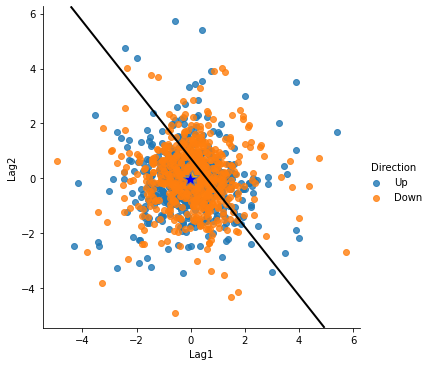

In [16]:

# library & dataset
import seaborn as sns
from matplotlib import colors
# Use the 'hue' argument to provide a factor variable
sns.lmplot( x="Lag1", y="Lag2", data=market, fit_reg=False, hue='Direction', legend=True)

nx, ny = 200, 100
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                        np.linspace(y_min, y_max, ny))
Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = Z[:, 1].reshape(xx.shape)

# decision boundary
plt.contour(xx, yy, Z, [0.5], linewidths=2., colors='black')
# means for the classes
plt.plot(model.means_[0][0], model.means_[0][1],
            '*', color='orange', markersize=15, markeredgecolor='grey')
plt.plot(model.means_[1][0], model.means_[1][1],
            '*', color='blue', markersize=15, markeredgecolor='grey')

The predict() function returns LDA's predictions about the movement of the market.

In [17]:

bin_predictions = model.predict(test[["Lag1", "Lag2"]])
predictions = ["Up" if n == 1 else "Down" for n in bin_predictions]

conf_matrix = confusion_matrix(y_true = test["Direction"], y_pred = predictions)
conf_matrix = pd.DataFrame(conf_matrix,index = ["Predicted Down", "Predicted Up"], columns = ["Test Down", "Test Up"])
conf_matrix
test_success = round(np.sum(np.diag(conf_matrix))/conf_matrix.values.sum(),2)
print(f"Correctly guessed on test set:{test_success} ")
print(f" Test error: {round(1-test_success, 2)}")


,Test Down,Test Up
Predicted Down,35,76
Predicted Up,35,106


Correctly guessed on test set:0.56 
 Test error: 0.44


Applying a 50 % threshold to the posterior probabilities allows us to recreate the predictions contained in model.predict_proba(). Notice that the posterior probability output by the model corresponds to
the probability that the market will decrease:

In [18]:
posterior = model.predict_proba(test[["Lag1", "Lag2"]])
print(f" Predicted to go up: {np.sum(posterior[:,1]>= 0.5) }")
print(f" Predicted to go down: {np.sum(posterior[:,1]< 0.5)}")

posterior[:10]

 Predicted to go up: 182
 Predicted to go down: 70


array([[0.49018, 0.50982],
       [0.47922, 0.52078],
       [0.46682, 0.53318],
       [0.474  , 0.526  ],
       [0.49279, 0.50721],
       [0.49386, 0.50614],
       [0.4951 , 0.5049 ],
       [0.48729, 0.51271],
       [0.4907 , 0.5093 ],
       [0.4844 , 0.5156 ]])

If we wanted to use a posterior probability threshold other than 50 % in
order to make predictions, then we could easily do so. For instance, suppose
that we wish to predict a market decrease only if we are very certain that the
market will indeed decrease on that day—say, if the posterior probability
is at least 90 %.

In [19]:
print(f" Predicted to go up with 0.9 treshhold: {np.sum(posterior[:,1]>= 0.9) }")


 Predicted to go up with 0.9 treshhold: 0


No days in 2005 meet that threshold! In fact, the greatest posterior probability of decrease in all of 2005 was 52.02 %.

### 4.6.4 Quadratic Discriminant Analysis

We will now fit a QDA model to the Smarket data. QDA is implemented in the sklearn module. The qda() syntax is identical to that of lda().

In [20]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

model = QDA()
model.fit(X_train, Y_train)

print('Class Priors (P(Y = k)) =', model.priors_)
print('Class Means μk\n   Down:', model.means_[0], '\n   Up:  ', model.means_[1])
print('Coeffecients =\n', model.scalings_)



QuadraticDiscriminantAnalysis()

Class Priors (P(Y = k)) = [0.49198 0.50802]
Class Means μk
   Down: [0.04279 0.03389] 
   Up:   [-0.03955 -0.03133]
Coeffecients =
 [array([1.56294, 1.47927]), array([1.53455, 1.47272])]


Interestingly, the QDA predictions are accurate almost 60 % of the time,
even though the 2005 data was not used to fit the model. This level of accuracy is quite impressive for stock market data, which is known to be quite
hard to model accurately. This suggests that the quadratic form assumed
by QDA may capture the true relationship more accurately than the linear
forms assumed by LDA and logistic regression. However, we recommend
evaluating this method’s performance on a larger test set before betting
that this approach will consistently beat the market!

### 4.6.5 K-Nearest Neighbors
We will now perform KNN using the `KNeighborsClassifier()` function, which is part of the `sklearn` module. 
We start with K=1:

In [23]:
from sklearn.neighbors import KNeighborsClassifier as KNNC

knn_1 = KNNC(n_neighbors=1)
knn_1.fit(X_train, train.Direction)
knn1_pred = knn_1.predict(test[["Lag1", "Lag2"]])

conf_matrix = confusion_matrix(y_true = test["Direction"], y_pred = knn1_pred)
conf_matrix = pd.DataFrame(conf_matrix,index = ["Predicted Down", "Predicted Up"], columns = ["Test Down", "Test Up"])
conf_matrix
test_success = round(np.sum(np.diag(conf_matrix))/conf_matrix.values.sum(),2)
print(f"Correctly guessed on test set with K=1:{test_success} ")
print(f" Test error with K=1: {round(1-test_success, 2)}")

KNeighborsClassifier(n_neighbors=1)

,Test Down,Test Up
Predicted Down,43,68
Predicted Up,58,83


Correctly guessed on test set:0.5 
 Test error: 0.5


The results using K = 1 are not very good, since only 50 % of the observations are correctly predicted. Of course, it may be that K = 1 results in an
overly flexible fit to the data. Below, we repeat the analysis using K = 3.



In [25]:
knn_3 = KNNC(n_neighbors=3)
knn_3.fit(X_train, train.Direction)
knn3_pred = knn_3.predict(test[["Lag1", "Lag2"]])

conf_matrix = confusion_matrix(y_true = test["Direction"], y_pred = knn3_pred)
conf_matrix = pd.DataFrame(conf_matrix,index = ["Predicted Down", "Predicted Up"], columns = ["Test Down", "Test Up"])
conf_matrix
test_success = round(np.sum(np.diag(conf_matrix))/conf_matrix.values.sum(),2)
print(f"Correctly guessed on test set with K=3: {test_success} ")
print(f" Test error with K=3: {round(1-test_success, 2)}")

KNeighborsClassifier(n_neighbors=3)

,Test Down,Test Up
Predicted Down,48,63
Predicted Up,55,86


Correctly guessed on test set with K=3:0.53 
 Test error with K=3: 0.47


The results have improved slightly. But increasing K further turns out
to provide no further improvements. It appears that for this data, QDA
provides the best results of the methods that we have examined so far

### 4.6.6 An Application to Caravan Insurance Data

Finally, we will apply the KNN approach to the `Caravan` data set. This data set includes 85 predictors that measure
demographic characteristics for 5,822 individuals. The response variable is
Purchase, which indicates whether or not a given individual purchases a
caravan insurance policy. In this data set, only 6 % of people purchased
caravan insurance.

In [30]:

# Load the caravan insurance data
caravan = pd.read_csv('Data/Caravan.csv', index_col=0)
caravan.head()
print("The data dimensions:")
caravan.shape
print("The Purchase column:")
caravan["Purchase"].describe()

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,Purchase
1,33,1,3,2,8,0,5,1,3,7,...,0,0,0,1,0,0,0,0,0,No
2,37,1,2,2,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,No
3,37,1,2,2,8,0,4,2,4,3,...,0,0,0,1,0,0,0,0,0,No
4,9,1,3,3,3,2,3,2,4,5,...,0,0,0,1,0,0,0,0,0,No
5,40,1,4,2,10,1,4,1,4,7,...,0,0,0,1,0,0,0,0,0,No


The data dimensions:


(5822, 86)

The Purchase column:


count     5822
unique       2
top         No
freq      5474
Name: Purchase, dtype: object

Because the KNN classifier predicts the class of a given test observation by
identifying the observations that are nearest to it, the scale of the variables
matters. Any variables that are on a large scale will have a much larger
effect on the distance between the observations, and hence on the KNN
classifier, than variables that are on a small scale. For instance, imagine a
data set that contains two variables, salary and age (measured in dollars
and years, respectively). As far as KNN is concerned, a difference of \$1,000
in salary is enormous compared to a difference of 50 years in age. Consequently, salary will drive the KNN classification results, and age will have
almost no effect. This is contrary to our intuition that a salary difference
of \$1,000 is quite small compared to an age difference of 50 years. Furthermore, the importance of scale to the KNN classifier leads to another issue:
if we measured salary in Japanese yen, or if we measured age in minutes,
then we’d get quite different classification results from what we get if these
two variables are measured in dollars and years.
A good way to handle this problem is to standardize the data so that all standardize
variables are given a mean of zero and a standard deviation of one. Then
all variables will be on a comparable scale. In standardizing the data, we exclude column 86, because that is the
qualitative Purchase variable.

In [35]:
from sklearn.preprocessing import scale

X = scale(caravan.drop(columns = "Purchase"), axis=0)
# check that X[:,1] is now standardized
print('mean =', np.mean(X[:,1]), 'variance = ', np.var(X[:,1]))

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,ALEVEN,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND
1,33,1,3,2,8,0,5,1,3,7,...,0,0,0,0,1,0,0,0,0,0
2,37,1,2,2,8,1,4,1,4,6,...,0,0,0,0,1,0,0,0,0,0
3,37,1,2,2,8,0,4,2,4,3,...,0,0,0,0,1,0,0,0,0,0
4,9,1,3,3,3,2,3,2,4,5,...,0,0,0,0,1,0,0,0,0,0
5,40,1,4,2,10,1,4,1,4,7,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5818,36,1,1,2,8,0,6,1,2,1,...,2,0,0,0,1,0,0,0,0,0
5819,35,1,4,4,8,1,4,1,4,6,...,0,0,0,0,1,0,0,0,0,0
5820,33,1,3,4,8,0,6,0,3,5,...,0,0,0,0,1,0,0,0,0,0
5821,34,1,3,2,8,0,7,0,2,7,...,0,0,0,0,0,0,0,0,0,0


mean = -1.6140377328112892e-16 variance =  1.0


We now split the observations into a test set, containing the first 1,000
observations, and a training set, containing the remaining observations.
We fit a KNN model on the training data using K = 1, and evaluate its
performance on the test data.

Comment: I am skeptical about standardizing before splitting into test/train, I would probably do it the other way around for industry applications 

In [58]:
Y = caravan.Purchase

X_train = X[1000:]
X_test = X[:1000]
Y_train = Y[1000:]
Y_test = Y[:1000]

knn_1 = KNNC(n_neighbors=1)
knn_1.fit(X_train, Y_train)
knn1_pred = knn_1.predict(X_test)

conf_matrix = confusion_matrix(y_true = Y_test, y_pred = knn1_pred)
conf_matrix = pd.DataFrame(conf_matrix, index = ["Predicted No", "Predicted Yes"], columns = ["Test No", "Test Yes"])
conf_matrix
test_success = round(np.sum(np.diag(conf_matrix))/conf_matrix.values.sum(),2)

print(f"Correctly guessed on test set with K=1:{test_success} ")
print(f" Test error with K=1: {round(1-test_success, 2)}")
print(f" Correctly predicted to buy: {round(9/(68+9), 3)}")






KNeighborsClassifier(n_neighbors=1)

,Test No,Test Yes
Predicted No,873,68
Predicted Yes,50,9


Correctly guessed on test set with K=1:0.88 
 Test error with K=1: 0.12
 Correctly predicted to buy: 0.117


x containing the observations
whose indices do not range from 1 to 1, 000. The KNN error rate on the
1,000 test observations is just under 12 %. At first glance, this may appear to be fairly good. However, since only 6 % of customers purchased
insurance, we could get the error rate down to 6 % by always predicting No
regardless of the values of the predictors!
Suppose that there is some non-trivial cost to trying to sell insurance
to a given individual. For instance, perhaps a salesperson must visit each
potential customer. If the company tries to sell insurance to a random
selection of customers, then the success rate will be only 6 %, which may
be far too low given the costs involved. Instead, the company would like
to try to sell insurance only to customers who are likely to buy it. So the
overall error rate is not of interest. Instead, the fraction of individuals that
are correctly predicted to buy insurance is of interest.
It turns out that KNN with K = 1 does far better than random guessing
among the customers that are predicted to buy insurance. Among 77 such
customers, 9, or 11.7 %, actually do purchase insurance. This is double the
rate that one would obtain from random guessing.

Using K = 3, the success rate increases to 20 %, and with K = 5 the rate is
26.7 %. This is over four times the rate that results from random guessing.
It appears that KNN is finding some real patterns in a difficult data set!

In [45]:
knn_3 = KNNC(n_neighbors=3)
knn_3.fit(X_train, Y_train)
knn3_pred = knn_3.predict(X_test)

conf_matrix = confusion_matrix(y_true = Y_test, y_pred = knn3_pred)
conf_matrix = pd.DataFrame(conf_matrix, index = ["Predicted No", "Predicted yes"], columns = ["Test No", "Test Yes"])
conf_matrix
test_success = round(np.sum(np.diag(conf_matrix))/conf_matrix.values.sum(),2)

print(f"Correctly guessed on test set with K=3:{test_success} ")
print(f" Test error with K=3: {round(1-test_success, 2)}")
print(f" Correctly predicted to buy: {round(5/(20+5), 3)}")

knn_5 = KNNC(n_neighbors=5)
knn_5.fit(X_train, Y_train)
knn5_pred = knn_5.predict(X_test)

conf_matrix = confusion_matrix(y_true = Y_test, y_pred = knn5_pred)
conf_matrix = pd.DataFrame(conf_matrix, index = ["Predicted No", "Predicted Yes"], columns = ["Test No", "Test Yes"])
conf_matrix
test_success = round(np.sum(np.diag(conf_matrix))/conf_matrix.values.sum(),2)

print(f"Correctly guessed on test set with K=5:{test_success} ")
print(f" Test error with K=5: {round(1-test_success, 2)}")
print(f" Correctly predicted to buy: {round(4/(11+4), 3)}")

KNeighborsClassifier(n_neighbors=3)

,Test Down,Test Up
Predicted Down,921,20
Predicted Up,54,5


Correctly guessed on test set with K=3:0.93 
 Test error with K=3: 0.07
 Correctly predicted to buy: 0.2


KNeighborsClassifier()

,Test Down,Test Up
Predicted Down,930,11
Predicted Up,55,4


Correctly guessed on test set with K=5:0.93 
 Test error with K=5: 0.07
 Correctly predicted to buy: 0.267


As a comparison, we can also fit a logistic regression model to the data.
If we use 0.5 as the predicted probability cut-off for the classifier, then
we have a problem: only seven of the test observations are predicted to
purchase insurance. Even worse, we are wrong about all of these! However,
we are not required to use a cut-off of 0.5. If we instead predict a purchase
any time the predicted probability of purchase exceeds 0.25, we get much
better results: we predict that 33 people will purchase insurance, and we
are correct for about 33 % of these people. This is over five times better
than random guessing!

In [74]:

# Using 0.5 as treshold
model = LogisticRegression( fit_intercept = True, solver='newton-cg', penalty = 'none')
model.fit(X_train, Y_train)
predictions = model.predict(X_test)
conf_matrix = confusion_matrix(y_true =Y_test, y_pred = predictions)
conf_matrix = pd.DataFrame(conf_matrix,index = ["Predicted No", "Predicted Yes"], columns = ["Test No", "Test Yes"])
conf_matrix
test_success = round(np.sum(np.diag(conf_matrix))/conf_matrix.values.sum(),2)
print("Treshold: 0.5")
print(f"Correctly guessed on test set:{test_success} ")
print(f" Test error: {round(1-test_success, 2)}")
print(f" Correctly predicted to buy: {0}")

# Using 0.25 as treshold

probs = model.predict_proba(X_test)
predictions = ["Yes"  if (prob > 0.25) else "No" for prob in probs[:,1]]
conf_matrix = confusion_matrix(y_true =Y_test, y_pred = predictions)
conf_matrix = pd.DataFrame(conf_matrix,index = ["Predicted No", "Predicted Yes"], columns = ["Test No", "Test Yes"])
conf_matrix
test_success = round(np.sum(np.diag(conf_matrix))/conf_matrix.values.sum(),2)
print("Treshold: 0.25")
print(f"Correctly guessed on test set:{test_success} ")
print(f" Test error: {round(1-test_success, 2)}")
print(f" Correctly predicted to buy: {round(11/(11+22), 3)}")


LogisticRegression(penalty='none', solver='newton-cg')

,Test No,Test Yes
Predicted No,934,7
Predicted Yes,59,0


Treshold: 0.5
Correctly guessed on test set:0.93 
 Test error: 0.07
 Correctly predicted to buy: 0


,Test No,Test Yes
Predicted No,919,22
Predicted Yes,48,11


Treshold: 0.25
Correctly guessed on test set:0.93 
 Test error: 0.07
 Correctly predicted to buy: 0.333
